In [112]:
import numpy as np
from numpy import cos, sin
import matplotlib.pyplot as plt
from libs.XY_model import XYSystem
import cv2
from tqdm import tqdm

In [113]:
N = 100
temp = 0.5

In [114]:
xy1 = XYSystem(temperature = temp, width = N)

#sweeps=1
energy=-0.55


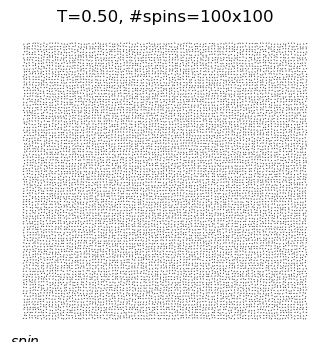


equilibrium state is reached at T=0.5
#sweep=518
energy=-1.70


In [115]:
xy1.equilibrate(show=True)

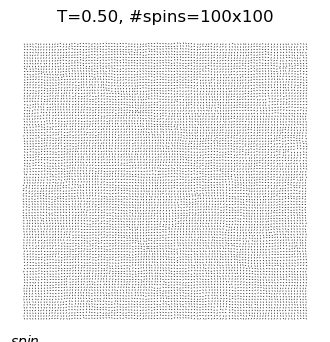

In [116]:
xy1.show()

In [117]:
x = np.reshape(xy1.spin_config, (-1, N))

In [131]:
curl = np.zeros([N, N])
neighbors = 30
for i in tqdm(range(N)):
    for j in range(N):
        for a in range(1, neighbors):
            curl[i, j] += (  ( (2 * cos(x[i, j])) - cos(x[(i+a)%N, j]) - cos(x[(i-a)%N, j])) -
                             ( (2 * sin(x[i, j]) - sin(x[i, (j+a)%N] - sin(x[i, (j-a)%N])))) )
curl /= neighbors

100%|██████████| 100/100 [00:00<00:00, 9151.47it/s]


In [132]:
max_curl = np.zeros([N, N])
thresh = 2
for i in range(N):
    for j in range(N):
        if(curl[i, j] >= thresh or curl[i, j] <= ((-1) * thresh)):
            max_curl[i, j] += curl[i, j]

In [133]:
N

100

In [134]:
def list2matrix(S):
        N=int(np.size(S))
        L = int(np.sqrt(N))
        S=np.reshape(S,(L,L))
        return S

In [135]:
def plot_heatmap(spin_config, curl, name = 'result'):
    X, Y = np.meshgrid(np.arange(0,N),np.arange(0, N))
    U = np.cos(spin_config)
    V = np.sin(spin_config)
    plt.figure(figsize=(4,4),dpi=400, facecolor='white')

    Q = plt.quiver(X, Y, U, V, units='width')
    qk = plt.quiverkey(Q, 0.1, 0.1, 1, r'$spin$', labelpos='E',
                coordinates='figure')
    plt.title('T=%.2f'%temp+', #spins='+str(N)+'x'+str(N))
    plt.imshow(curl)
    plt.axis('off')
    plt.savefig(f'./{name}.png', dpi = 400)
    plt.close()

In [136]:
plot_heatmap(xy1.spin_config, curl, 'curl')

In [137]:
plot_heatmap(xy1.spin_config, max_curl, 'max_curl')